In [59]:
#importing libraries

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import copy

In [60]:
from google.colab import drive
drive.mount('/content/drive')

DataFolder = "/content/drive/My Drive/Colab Notebooks/geneticsProject/data/"

# CONFIG
SAMPLE_SIZE =200
CHANGE_SAMPLE_AFTER = 15

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
class Config:
    MAX_INSTRUCTION_SET_LENGTH = 256
    INIT_MAX_INSTRUCTION_SET_LENGTH = 128
    MIN_INSTRUCTION_SET_LENGTH = 8
    TOTAL_OUTPUT_REGISTER = 10
    TOTAL_OPERATIONS = 4

    #PAR TO TUNE!
    GAP_PERCENTAGE = 20
    MUTATION_PROBABILITY = 90
    CROSSOVER_PROBABILITY = 90
    POPULATION_SIZE = 150
    SAME_NUMBER_OF_ITERATIONS = 50

### Get Data

In [62]:
def getDataFromFile(fileName):
  #Read File
  df = pd.read_csv(fileName, sep=" " ,header=None)
  data = df.dropna(axis=1)

  return data

In [63]:
def getData(target):
  trainFile = DataFolder + target +"/train.txt"
  testFile = DataFolder + target +"/test.txt"

  #Training Data
  trainData =  getDataFromFile(trainFile)

  #Post Training Evaluation
  testData =  getDataFromFile(testFile)

  return trainData,testData


In [64]:
def getuniformSample(data, sampleSize, lableSize):
  print("CREATING SAMPLE")
  classesIndex = (data.shape)[1] - 1
  allLables = data[classesIndex].unique()

  #empty Sample df
  sample = pd.DataFrame()
  tempData = data[:]

  while(len(sample) < sampleSize):
    lableToSelect = random.choice(allLables)
    dataForClass = tempData[tempData[classesIndex] == (lableToSelect)]
    selectedData = dataForClass.sample(n=1, replace=False)
    sample = sample.append(selectedData)
    tempData.drop(selectedData.index)
    
  return sample

In [65]:
def splitDataForXandY(data):
  X = data[data.columns[:-1]]
  Y = data[data.columns[-1]]
  
  # one hot encode lable
  Y = pd.get_dummies(Y)
  
  X = X.values.tolist()
  Y = Y.values.tolist()
  
  return X,Y

### Creating Individuals and population

In [66]:
class Individual:
    # Operators = [+, -, /2, *2]
    # Operators = [0, 1,  2 , 3]
    # instructionSet = [ Select | target Register | operator| source ]

    def __init__(self, instructionSet):
        self.instructionSet = instructionSet
        self.registers = [0] * Config.TOTAL_OUTPUT_REGISTER
        self.fitnessScore = 0

    def reset(self):
        self.registers = [0] * Config.TOTAL_OUTPUT_REGISTER

    def resetFitness(self):
        self.fitnessScore = 0

    def isValid(self):
        if( (len(self.instructionSet) > Config.MIN_INSTRUCTION_SET_LENGTH) and (len(self.instructionSet) < Config.MAX_INSTRUCTION_SET_LENGTH)):
            return True
        else:
            return False

    def runProgram(self, data):
        self.reset()
        for instruction in self.instructionSet:
            select = instruction[0]
            target = instruction[1]
            operator = instruction[2]
            source = instruction[3]

            if select == 0:
                source = source%len(data)
                source = data[source]
            else:
                source = source % Config.TOTAL_OUTPUT_REGISTER
                source = self.registers[source]

            if operator == 0:
                self.registers[target] = self.registers[target] + source
            if operator == 1:
                self.registers[target] = self.registers[target] - source
            if operator == 2:
                self.registers[target] = self.registers[target] / 2
            if operator == 3:
                self.registers[target] = self.registers[target] * 2

    def predict(self, data, lable):

        self.runProgram(data)

        maxLableIndex = np.array(lable).argmax()
        maxRegisterIndex = np.array(self.registers[:len(lable)]).argmax()

        if maxLableIndex == maxRegisterIndex:
            return True
        else:
            return False

In [67]:
def getInstructionSet(dataLen):
  
  configOb = Config()

  #randomly selecting the length of instruction set
  endIndex = random.randint(2,configOb.INIT_MAX_INSTRUCTION_SET_LENGTH)
  instructionSet = list()
  for i in range(endIndex):
    selectBit = random.randint(0,1)
    targetValue = random.randint(0,configOb.TOTAL_OUTPUT_REGISTER - 1)
    operator = random.randint(0,configOb.TOTAL_OPERATIONS - 1)
    source = random.randint(0,max(dataLen, configOb.TOTAL_OUTPUT_REGISTER ) - 1 )

    instruction = [selectBit, targetValue, operator, source]
    instructionSet.append(instruction)

  return instructionSet

In [68]:
def createGenotype(X):
  dataLen = len(X[0])
  populationList = list()
  for i in range(Config.POPULATION_SIZE):
    individualInstructionSet = getInstructionSet(dataLen)
    individualOb = Individual(individualInstructionSet)
    populationList.append(individualOb)
    
  print(str(len(populationList)) + " individuals created.")
  return populationList

### Methods for GL

In [69]:
class TwoPointCrossover:

  def getBiasedCrossoverPoints(self, parent):
    n = len(parent.instructionSet)
    temp = 1
    myList = []
    while (temp <= n):
      tempList = [temp-1]*temp
      myList = myList + tempList
      temp +=1

    crossoverPoint1 = random.choice(myList)
    crossoverPoint2 = random.choice(myList)
    while (crossoverPoint1 == crossoverPoint2 or crossoverPoint1 > crossoverPoint2):
      crossoverPoint1 = random.choice(myList)
      crossoverPoint2 = random.choice(myList)

    return crossoverPoint1,crossoverPoint2
  
  def getTwoCrossoverPoints(self, parent):
    crossoverPoint1 = 0
    crossoverPoint2 = 0
    while (crossoverPoint1 == crossoverPoint2):
      crossoverPoint1 = random.randint(0, len(parent.instructionSet) - 2)
      crossoverPoint2 = random.randint(crossoverPoint1 + 1, len(parent.instructionSet) - 1)
      
    return crossoverPoint1,crossoverPoint2
    
  def createChild(self, parent1, parent2, p1CP1,p1CP2, p2CP1,p2CP2 ):
    childInstructionSet = parent1.instructionSet[:p1CP1 - 1]
    childInstructionSet = childInstructionSet + parent2.instructionSet[p2CP1: p2CP2]
    childInstructionSet = childInstructionSet + parent1.instructionSet[p1CP2 + 1:]

    child = Individual(childInstructionSet)

    return child
  
  def crossover(self, parent1, parent2):
    p1CP1, p1CP2 = self.getBiasedCrossoverPoints(parent1)
    p2CP1, p2CP2 = self.getBiasedCrossoverPoints(parent2)

    child1 = self.createChild(parent1, parent2, p1CP1, p1CP2, p2CP1, p2CP2)

    child2 = self.createChild(parent2, parent1, p2CP1, p2CP2, p1CP1, p1CP2)

    if (not (child1.isValid())):
      child1 = None
      if (not (child2.isValid())):
        child2 = None
    return child1, child2

In [70]:
class Mutation:

    mutationTypes = 3

    def swapMutation(self, child):
        bit1 = random.randint(0, len(child.instructionSet) - 1)
        bit2 = random.randint(0, len(child.instructionSet) - 1)
        #print("Swapping bit: ",bit1, "and ", bit2)
        child.instructionSet[bit1], child.instructionSet[bit2] = child.instructionSet[bit2], child.instructionSet[bit1]

        return child

    def reverseMutation(self, child):
        bit1 = random.randint(0, len(child.instructionSet) - 2)
        bit2 = random.randint(bit1+1, len(child.instructionSet) - 1)

        mutatedChild = child.instructionSet[0:bit1] + child.instructionSet[bit2: bit1-1: -1] + child.instructionSet[bit2+1:]
        mutatedChild = Individual(mutatedChild)

        return mutatedChild

    def scrambleMutation(self, child):
        bit1 = random.randint(0, len(child.instructionSet) - 2)
        bit2 = random.randint(bit1 + 1, len(child.instructionSet) - 1)

        temp = child.instructionSet[bit1: bit2]
        random.shuffle(temp)
        mutatedList = child.instructionSet[:bit1] + temp + child.instructionSet[bit2:]
        mutatedChild = Individual(mutatedList)

        return mutatedChild

    def mutateIndividual(self, childToMutate):
        child = childToMutate
        type = random.randint(0, self.mutationTypes - 1)
        if (random.randint(0, 100) < Config.MUTATION_PROBABILITY):
            if (type == 0):
                child = self.swapMutation(child)
            if (type == 1):
                child = self.reverseMutation(child)
            if (type == 2):
                child = self.scrambleMutation(child)

        return child

In [71]:
def calculateFitness(populationList, data, lable):
  for person in populationList:
    correctPrediction = 0
    person.resetFitness()
    for i in range(len(data)):
      answer = person.predict(data[i] , lable[i])
      correctPrediction += answer

    fitness = 100*(correctPrediction/len(data))
    person.fitnessScore = fitness

In [72]:
def getGapedPopulation(populationList):
  sortedPopulation = sorted(populationList, key=lambda x: x.fitnessScore, reverse=True)
  
  totalGap = (Config.GAP_PERCENTAGE * len(sortedPopulation)) / 100
  
  gapedPopulation = sortedPopulation[: int(len(sortedPopulation)- totalGap)]
  return gapedPopulation

In [73]:
def isChildReadyToPush(populationList, child,newPopulation):
  crossoverChance = random.randint(0, 100) < Config.CROSSOVER_PROBABILITY
  if (crossoverChance and (not (child is None)) and (len(newPopulation) < len(populationList))):
    return True
  else:
    return False

In [74]:

def breed(populationList, gapedPopulation):
  newPopulation = gapedPopulation[:]
  while (len(newPopulation) < len(populationList)):
    parent1 = random.choice(gapedPopulation)
    parent2 = random.choice(gapedPopulation)
    if (len(parent1.instructionSet) > 5 and len(parent2.instructionSet) > 5):
      child1,child2 = TwoPointCrossover().crossover(parent1, parent2)
    else:
      break
    mutationOb = Mutation()
    
    if (isChildReadyToPush(populationList, child1, newPopulation)):
      mutatedChild = mutationOb.mutateIndividual(child1)
      newPopulation.append(mutatedChild)
      
      if (isChildReadyToPush(populationList,child2,newPopulation)):
        mutatedChild = mutationOb.mutateIndividual(child2)
        newPopulation.append(mutatedChild)
  
  return newPopulation

### Making Data for visualization 

In [75]:
def pushToGenerationAccuracyDictionary(classwiseAccuracy,classWiseAccuracyInGeneration):
  for key in classwiseAccuracy.keys():
    if key in classWiseAccuracyInGeneration:
      classWiseAccuracyInGeneration[key].append(classwiseAccuracy[key])
    else:
      classWiseAccuracyInGeneration[key] = []
      classWiseAccuracyInGeneration[key].append(classwiseAccuracy[key])

In [76]:
def calculateClasswiseAccuracy(individual, data, lable, classWiseAccuracyInGeneration):
  classwiseAccuracy = dict()
  for i in range(len(data)):
    lableToPush = tuple(lable[i])
    answer = individual.predict(data[i], lable[i])
    if (answer):
      if (lableToPush in classwiseAccuracy):
        classwiseAccuracy[lableToPush] += 1
      else:
        classwiseAccuracy[lableToPush] = 1
    else:
      if (lableToPush in classwiseAccuracy):
        classwiseAccuracy[lableToPush] += 0
      else:
        classwiseAccuracy[lableToPush] = 0
  pushToGenerationAccuracyDictionary(classwiseAccuracy, classWiseAccuracyInGeneration)

### Training Model

In [77]:
#method to run everything
def runGA(targetFile, accuracy):
  trainData,testData = getData(targetFile)
  attributes = (trainData.shape)[1] - 1
  classes = len(trainData[attributes].unique())
  print("Data contains", attributes, "and", classes, "classes")

  sample = getuniformSample(trainData, SAMPLE_SIZE, classes)
  

  X, Y = splitDataForXandY(sample)
  X_test, Y_test = splitDataForXandY(testData)

  #init Population
  populationList = list()
  populationList = createGenotype(X)

  classWiseAccuracyInGeneration = dict()

  generationAccuracy = 0
  desiredAccuracy = accuracy
  generationCount = 0
  accuracyOverGenerations = list()
  testAccuracy = list()

  while (generationAccuracy < desiredAccuracy):
    if (generationCount % CHANGE_SAMPLE_AFTER == 0):
      sample = getuniformSample(trainData, SAMPLE_SIZE, classes)
      X, Y = splitDataForXandY(sample)
      
    calculateFitness(populationList, X, Y)
    gapedPopulation = getGapedPopulation(populationList)

    mostFitIndi = gapedPopulation[0]
    calculateClasswiseAccuracy(mostFitIndi, X, Y,classWiseAccuracyInGeneration)
    
    accuracyOverGenerations.append(round(gapedPopulation[0].fitnessScore, 2))
    print("Generation ", generationCount + 1, " Accuracy = ", accuracyOverGenerations[generationCount])

    newPopulation = breed(populationList, gapedPopulation)
    populationList = newPopulation
    generationAccuracy = accuracyOverGenerations[generationCount]
    generationCount += 1

    calculateFitness([gapedPopulation[0]], X_test, Y_test)
    testAccuracy.append(round(gapedPopulation[0].fitnessScore, 2))
    
    if(len(accuracyOverGenerations) > 30):
      checkList = accuracyOverGenerations[-25:]
      result = checkList.count(checkList[0]) == len(checkList)
      if (result):
        print("Same Accuracy for last 25 generations")
        break

  
  return generationCount,accuracyOverGenerations,testAccuracy

In [78]:
class ModelInfo():
  def __init__(self, generationCount,accuracyOverGenerations,testAccuracy ):
        self.generationCount = generationCount
        self.trainAccuracy = accuracyOverGenerations
        self.testAccuracy = testAccuracy

Running GA for Dataset: abalone desired Accuracy: 60
RUN - 0
Data contains 8 and 4 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  43.5
Generation  2  Accuracy =  43.5
Generation  3  Accuracy =  43.5
Generation  4  Accuracy =  43.5
Generation  5  Accuracy =  43.5
Generation  6  Accuracy =  44.0
Generation  7  Accuracy =  44.0
Generation  8  Accuracy =  44.0
Generation  9  Accuracy =  44.0
Generation  10  Accuracy =  44.0
Generation  11  Accuracy =  44.0
Generation  12  Accuracy =  44.0
Generation  13  Accuracy =  44.0
Generation  14  Accuracy =  44.0
Generation  15  Accuracy =  44.0
CREATING SAMPLE
Generation  16  Accuracy =  46.5
Generation  17  Accuracy =  46.5
Generation  18  Accuracy =  46.5
Generation  19  Accuracy =  46.5
Generation  20  Accuracy =  46.5
Generation  21  Accuracy =  46.5
Generation  22  Accuracy =  46.5
Generation  23  Accuracy =  46.5
Generation  24  Accuracy =  46.5
Generation  25  Accuracy =  46.5
Generation  26  Accu

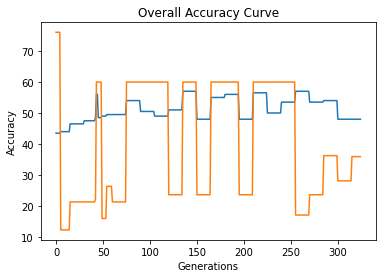

RUN - 1
Data contains 8 and 4 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  51.5
Generation  2  Accuracy =  51.5
Generation  3  Accuracy =  51.5
Generation  4  Accuracy =  51.5
Generation  5  Accuracy =  51.5
Generation  6  Accuracy =  51.5
Generation  7  Accuracy =  51.5
Generation  8  Accuracy =  51.5
Generation  9  Accuracy =  51.5
Generation  10  Accuracy =  51.5
Generation  11  Accuracy =  51.5
Generation  12  Accuracy =  51.5
Generation  13  Accuracy =  51.5
Generation  14  Accuracy =  51.5
Generation  15  Accuracy =  52.5
CREATING SAMPLE
Generation  16  Accuracy =  47.5
Generation  17  Accuracy =  47.5
Generation  18  Accuracy =  47.5
Generation  19  Accuracy =  47.5
Generation  20  Accuracy =  47.5
Generation  21  Accuracy =  47.5
Generation  22  Accuracy =  47.5
Generation  23  Accuracy =  47.5
Generation  24  Accuracy =  47.5
Generation  25  Accuracy =  48.0
Generation  26  Accuracy =  48.5
Generation  27  Accuracy =  48.5
Generat

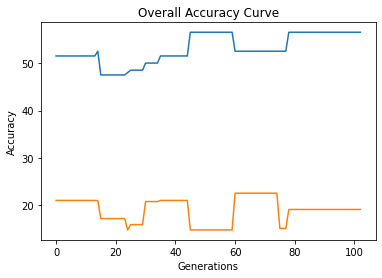

RUN - 2
Data contains 8 and 4 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  43.0
Generation  2  Accuracy =  43.0
Generation  3  Accuracy =  43.0
Generation  4  Accuracy =  43.0
Generation  5  Accuracy =  44.0
Generation  6  Accuracy =  44.0
Generation  7  Accuracy =  48.5
Generation  8  Accuracy =  48.5
Generation  9  Accuracy =  48.5
Generation  10  Accuracy =  48.5
Generation  11  Accuracy =  48.5
Generation  12  Accuracy =  48.5
Generation  13  Accuracy =  48.5
Generation  14  Accuracy =  48.5
Generation  15  Accuracy =  48.5
CREATING SAMPLE
Generation  16  Accuracy =  50.0
Generation  17  Accuracy =  50.0
Generation  18  Accuracy =  50.0
Generation  19  Accuracy =  50.0
Generation  20  Accuracy =  50.0
Generation  21  Accuracy =  50.5
Generation  22  Accuracy =  50.5
Generation  23  Accuracy =  50.5
Generation  24  Accuracy =  50.5
Generation  25  Accuracy =  50.5
Generation  26  Accuracy =  50.5
Generation  27  Accuracy =  50.5
Generat

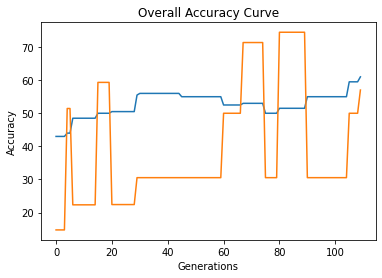

RUN - 3
Data contains 8 and 4 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  46.0
Generation  2  Accuracy =  46.0
Generation  3  Accuracy =  46.0
Generation  4  Accuracy =  46.0
Generation  5  Accuracy =  46.0
Generation  6  Accuracy =  46.0
Generation  7  Accuracy =  46.0
Generation  8  Accuracy =  46.0
Generation  9  Accuracy =  46.0
Generation  10  Accuracy =  46.0
Generation  11  Accuracy =  46.0
Generation  12  Accuracy =  46.0
Generation  13  Accuracy =  46.0
Generation  14  Accuracy =  46.0
Generation  15  Accuracy =  46.0
CREATING SAMPLE
Generation  16  Accuracy =  51.5
Generation  17  Accuracy =  51.5
Generation  18  Accuracy =  51.5
Generation  19  Accuracy =  51.5
Generation  20  Accuracy =  55.5
Generation  21  Accuracy =  55.5
Generation  22  Accuracy =  55.5
Generation  23  Accuracy =  55.5
Generation  24  Accuracy =  55.5
Generation  25  Accuracy =  55.5
Generation  26  Accuracy =  55.5
Generation  27  Accuracy =  55.5
Generat

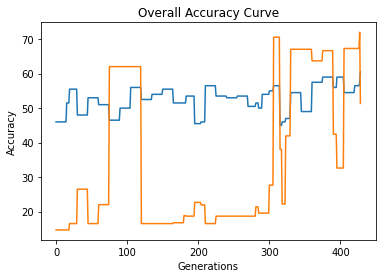

RUN - 4
Data contains 8 and 4 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  43.5
Generation  2  Accuracy =  43.5
Generation  3  Accuracy =  43.5
Generation  4  Accuracy =  43.5
Generation  5  Accuracy =  43.5
Generation  6  Accuracy =  43.5
Generation  7  Accuracy =  43.5
Generation  8  Accuracy =  43.5
Generation  9  Accuracy =  43.5
Generation  10  Accuracy =  45.5
Generation  11  Accuracy =  45.5
Generation  12  Accuracy =  45.5
Generation  13  Accuracy =  45.5
Generation  14  Accuracy =  46.0
Generation  15  Accuracy =  46.0
CREATING SAMPLE
Generation  16  Accuracy =  50.0
Generation  17  Accuracy =  50.0
Generation  18  Accuracy =  50.0
Generation  19  Accuracy =  50.0
Generation  20  Accuracy =  50.0
Generation  21  Accuracy =  50.0
Generation  22  Accuracy =  50.0
Generation  23  Accuracy =  50.0
Generation  24  Accuracy =  50.0
Generation  25  Accuracy =  50.0
Generation  26  Accuracy =  50.0
Generation  27  Accuracy =  50.0
Generat

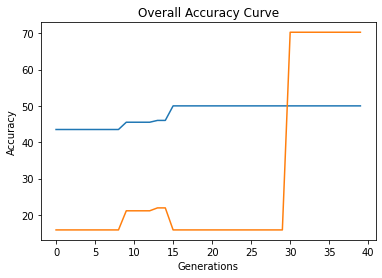

Running GA for Dataset: bank desired Accuracy: 85
RUN - 0
Data contains 16 and 2 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  69.0
Generation  2  Accuracy =  72.5
Generation  3  Accuracy =  72.5
Generation  4  Accuracy =  72.5
Generation  5  Accuracy =  72.5
Generation  6  Accuracy =  72.5
Generation  7  Accuracy =  72.5
Generation  8  Accuracy =  73.0
Generation  9  Accuracy =  73.0
Generation  10  Accuracy =  73.0
Generation  11  Accuracy =  73.0
Generation  12  Accuracy =  73.0
Generation  13  Accuracy =  73.0
Generation  14  Accuracy =  73.0
Generation  15  Accuracy =  73.0
CREATING SAMPLE
Generation  16  Accuracy =  74.5
Generation  17  Accuracy =  74.5
Generation  18  Accuracy =  74.5
Generation  19  Accuracy =  74.5
Generation  20  Accuracy =  74.5
Generation  21  Accuracy =  74.5
Generation  22  Accuracy =  75.0
Generation  23  Accuracy =  75.0
Generation  24  Accuracy =  75.0
Generation  25  Accuracy =  75.0
Generation  26  Accura

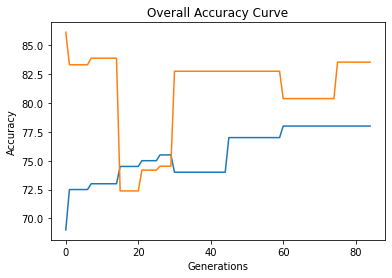

RUN - 1
Data contains 16 and 2 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  69.0
Generation  2  Accuracy =  69.0
Generation  3  Accuracy =  69.0
Generation  4  Accuracy =  69.0
Generation  5  Accuracy =  69.0
Generation  6  Accuracy =  69.0
Generation  7  Accuracy =  69.0
Generation  8  Accuracy =  69.0
Generation  9  Accuracy =  69.0
Generation  10  Accuracy =  69.0
Generation  11  Accuracy =  69.0
Generation  12  Accuracy =  69.0
Generation  13  Accuracy =  69.0
Generation  14  Accuracy =  69.0
Generation  15  Accuracy =  69.0
CREATING SAMPLE
Generation  16  Accuracy =  71.5
Generation  17  Accuracy =  71.5
Generation  18  Accuracy =  73.0
Generation  19  Accuracy =  73.0
Generation  20  Accuracy =  73.0
Generation  21  Accuracy =  73.5
Generation  22  Accuracy =  75.0
Generation  23  Accuracy =  75.0
Generation  24  Accuracy =  75.0
Generation  25  Accuracy =  75.0
Generation  26  Accuracy =  75.0
Generation  27  Accuracy =  75.0
Genera

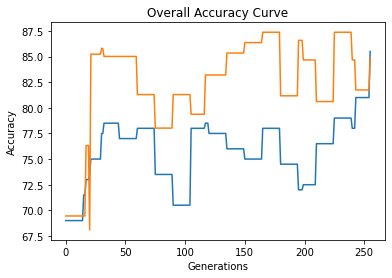

RUN - 2
Data contains 16 and 2 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  79.0
Generation  2  Accuracy =  79.0
Generation  3  Accuracy =  79.0
Generation  4  Accuracy =  79.0
Generation  5  Accuracy =  79.0
Generation  6  Accuracy =  79.0
Generation  7  Accuracy =  79.0
Generation  8  Accuracy =  79.0
Generation  9  Accuracy =  79.0
Generation  10  Accuracy =  79.0
Generation  11  Accuracy =  79.0
Generation  12  Accuracy =  79.0
Generation  13  Accuracy =  79.0
Generation  14  Accuracy =  79.0
Generation  15  Accuracy =  79.0
CREATING SAMPLE
Generation  16  Accuracy =  72.0
Generation  17  Accuracy =  72.0
Generation  18  Accuracy =  72.0
Generation  19  Accuracy =  72.0
Generation  20  Accuracy =  72.0
Generation  21  Accuracy =  72.0
Generation  22  Accuracy =  72.0
Generation  23  Accuracy =  72.0
Generation  24  Accuracy =  72.0
Generation  25  Accuracy =  72.0
Generation  26  Accuracy =  72.0
Generation  27  Accuracy =  72.0
Genera

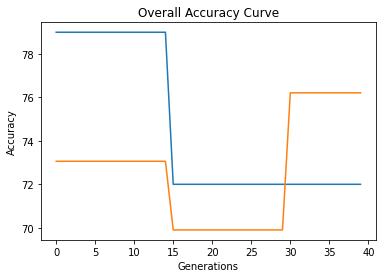

RUN - 3
Data contains 16 and 2 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  74.0
Generation  2  Accuracy =  74.0
Generation  3  Accuracy =  74.0
Generation  4  Accuracy =  74.0
Generation  5  Accuracy =  74.0
Generation  6  Accuracy =  74.0
Generation  7  Accuracy =  74.0
Generation  8  Accuracy =  74.0
Generation  9  Accuracy =  74.0
Generation  10  Accuracy =  74.0
Generation  11  Accuracy =  74.0
Generation  12  Accuracy =  74.0
Generation  13  Accuracy =  74.0
Generation  14  Accuracy =  74.0
Generation  15  Accuracy =  74.0
CREATING SAMPLE
Generation  16  Accuracy =  70.0
Generation  17  Accuracy =  70.0
Generation  18  Accuracy =  70.0
Generation  19  Accuracy =  73.5
Generation  20  Accuracy =  78.5
Generation  21  Accuracy =  78.5
Generation  22  Accuracy =  78.5
Generation  23  Accuracy =  78.5
Generation  24  Accuracy =  78.5
Generation  25  Accuracy =  78.5
Generation  26  Accuracy =  78.5
Generation  27  Accuracy =  78.5
Genera

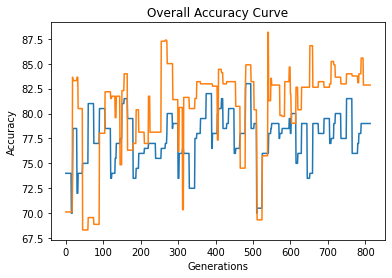

RUN - 4
Data contains 16 and 2 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  73.0
Generation  2  Accuracy =  73.0
Generation  3  Accuracy =  73.0
Generation  4  Accuracy =  73.0
Generation  5  Accuracy =  73.0
Generation  6  Accuracy =  73.0
Generation  7  Accuracy =  73.0
Generation  8  Accuracy =  73.0
Generation  9  Accuracy =  73.0
Generation  10  Accuracy =  73.0
Generation  11  Accuracy =  73.0
Generation  12  Accuracy =  73.0
Generation  13  Accuracy =  73.0
Generation  14  Accuracy =  73.0
Generation  15  Accuracy =  73.0
CREATING SAMPLE
Generation  16  Accuracy =  76.5
Generation  17  Accuracy =  76.5
Generation  18  Accuracy =  76.5
Generation  19  Accuracy =  76.5
Generation  20  Accuracy =  76.5
Generation  21  Accuracy =  76.5
Generation  22  Accuracy =  76.5
Generation  23  Accuracy =  76.5
Generation  24  Accuracy =  76.5
Generation  25  Accuracy =  76.5
Generation  26  Accuracy =  76.5
Generation  27  Accuracy =  76.5
Genera

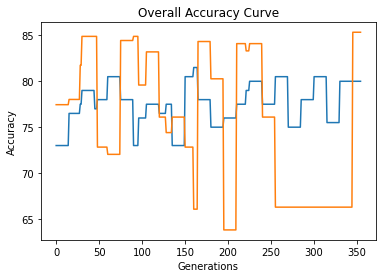

Running GA for Dataset: thyroid desired Accuracy: 90
RUN - 0
Data contains 21 and 3 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  62.5
Generation  2  Accuracy =  62.5
Generation  3  Accuracy =  62.5
Generation  4  Accuracy =  62.5
Generation  5  Accuracy =  62.5
Generation  6  Accuracy =  62.5
Generation  7  Accuracy =  62.5
Generation  8  Accuracy =  63.5
Generation  9  Accuracy =  63.5
Generation  10  Accuracy =  63.5
Generation  11  Accuracy =  63.5
Generation  12  Accuracy =  63.5
Generation  13  Accuracy =  63.5
Generation  14  Accuracy =  63.5
Generation  15  Accuracy =  63.5
CREATING SAMPLE
Generation  16  Accuracy =  59.0
Generation  17  Accuracy =  59.0
Generation  18  Accuracy =  60.5
Generation  19  Accuracy =  61.0
Generation  20  Accuracy =  61.0
Generation  21  Accuracy =  61.0
Generation  22  Accuracy =  61.0
Generation  23  Accuracy =  61.0
Generation  24  Accuracy =  61.0
Generation  25  Accuracy =  61.0
Generation  26  Acc

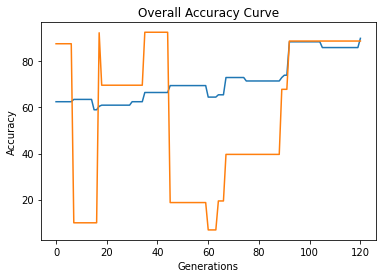

RUN - 1
Data contains 21 and 3 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  46.0
Generation  2  Accuracy =  52.0
Generation  3  Accuracy =  66.0
Generation  4  Accuracy =  66.0
Generation  5  Accuracy =  66.0
Generation  6  Accuracy =  66.0
Generation  7  Accuracy =  66.0
Generation  8  Accuracy =  66.0
Generation  9  Accuracy =  66.0
Generation  10  Accuracy =  66.0
Generation  11  Accuracy =  66.0
Generation  12  Accuracy =  66.0
Generation  13  Accuracy =  66.0
Generation  14  Accuracy =  66.0
Generation  15  Accuracy =  66.0
CREATING SAMPLE
Generation  16  Accuracy =  58.5
Generation  17  Accuracy =  58.5
Generation  18  Accuracy =  58.5
Generation  19  Accuracy =  58.5
Generation  20  Accuracy =  58.5
Generation  21  Accuracy =  58.5
Generation  22  Accuracy =  58.5
Generation  23  Accuracy =  58.5
Generation  24  Accuracy =  58.5
Generation  25  Accuracy =  58.5
Generation  26  Accuracy =  61.5
Generation  27  Accuracy =  61.5
Genera

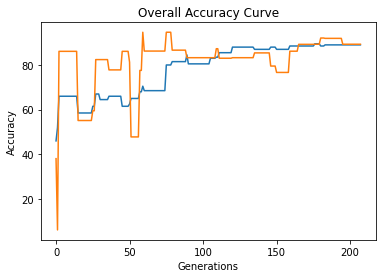

RUN - 2
Data contains 21 and 3 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  61.0
Generation  2  Accuracy =  61.0
Generation  3  Accuracy =  61.0
Generation  4  Accuracy =  61.0
Generation  5  Accuracy =  61.0
Generation  6  Accuracy =  61.0
Generation  7  Accuracy =  61.0
Generation  8  Accuracy =  61.0
Generation  9  Accuracy =  61.0
Generation  10  Accuracy =  61.0
Generation  11  Accuracy =  61.0
Generation  12  Accuracy =  61.0
Generation  13  Accuracy =  61.0
Generation  14  Accuracy =  61.0
Generation  15  Accuracy =  61.0
CREATING SAMPLE
Generation  16  Accuracy =  60.5
Generation  17  Accuracy =  60.5
Generation  18  Accuracy =  60.5
Generation  19  Accuracy =  60.5
Generation  20  Accuracy =  61.5
Generation  21  Accuracy =  61.5
Generation  22  Accuracy =  61.5
Generation  23  Accuracy =  61.5
Generation  24  Accuracy =  63.0
Generation  25  Accuracy =  63.0
Generation  26  Accuracy =  63.0
Generation  27  Accuracy =  66.5
Genera

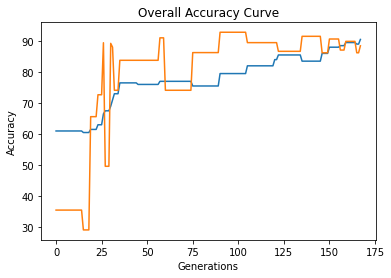

RUN - 3
Data contains 21 and 3 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  51.0
Generation  2  Accuracy =  51.0
Generation  3  Accuracy =  51.0
Generation  4  Accuracy =  51.0
Generation  5  Accuracy =  51.0
Generation  6  Accuracy =  66.0
Generation  7  Accuracy =  66.0
Generation  8  Accuracy =  66.0
Generation  9  Accuracy =  66.0
Generation  10  Accuracy =  66.0
Generation  11  Accuracy =  66.0
Generation  12  Accuracy =  66.0
Generation  13  Accuracy =  66.0
Generation  14  Accuracy =  66.0
Generation  15  Accuracy =  66.0
CREATING SAMPLE
Generation  16  Accuracy =  61.5
Generation  17  Accuracy =  61.5
Generation  18  Accuracy =  61.5
Generation  19  Accuracy =  61.5
Generation  20  Accuracy =  61.5
Generation  21  Accuracy =  61.5
Generation  22  Accuracy =  61.5
Generation  23  Accuracy =  61.5
Generation  24  Accuracy =  61.5
Generation  25  Accuracy =  61.5
Generation  26  Accuracy =  76.5
Generation  27  Accuracy =  76.5
Genera

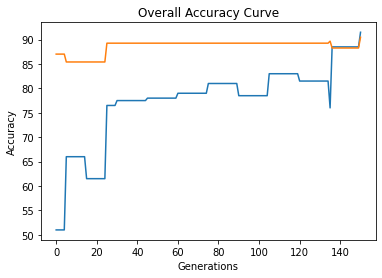

RUN - 4
Data contains 21 and 3 classes
CREATING SAMPLE
150 individuals created.
CREATING SAMPLE
Generation  1  Accuracy =  66.5
Generation  2  Accuracy =  66.5
Generation  3  Accuracy =  66.5
Generation  4  Accuracy =  66.5
Generation  5  Accuracy =  66.5
Generation  6  Accuracy =  66.5
Generation  7  Accuracy =  66.5
Generation  8  Accuracy =  66.5
Generation  9  Accuracy =  66.5
Generation  10  Accuracy =  66.5
Generation  11  Accuracy =  66.5
Generation  12  Accuracy =  66.5
Generation  13  Accuracy =  66.5
Generation  14  Accuracy =  67.0
Generation  15  Accuracy =  67.0
CREATING SAMPLE
Generation  16  Accuracy =  62.0
Generation  17  Accuracy =  62.0
Generation  18  Accuracy =  62.0
Generation  19  Accuracy =  62.0
Generation  20  Accuracy =  62.0
Generation  21  Accuracy =  62.0
Generation  22  Accuracy =  62.0
Generation  23  Accuracy =  62.0
Generation  24  Accuracy =  62.0
Generation  25  Accuracy =  62.0
Generation  26  Accuracy =  62.0
Generation  27  Accuracy =  62.0
Genera

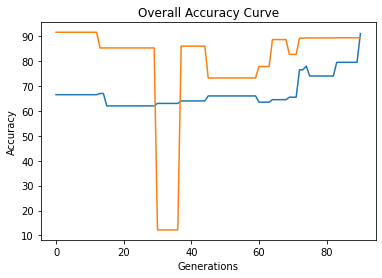

In [79]:
datasetList = ['abalone','bank','thyroid']
accuracy = [60, 85, 90]
modelInfo = {}
a = 0
for dataset in datasetList:
  modelList = []
  print("========================================================================")
  print("Running GA for Dataset:", dataset, "desired Accuracy:", accuracy[a])
  print("========================================================================")
  for i in range(5):
    print("========================================================================")
    print("RUN -",i)
    print("========================================================================")
    generationCount,accuracyOverGenerations,testAccuracy = runGA(dataset, accuracy[a])
    plt.plot(range(len(accuracyOverGenerations)), accuracyOverGenerations)
    plt.plot(range(len(accuracyOverGenerations)), testAccuracy)
    plt.xlabel("Generations")
    plt.ylabel("Accuracy")
    plt.title("Overall Accuracy Curve") 
    plt.show()
    modelObject = ModelInfo(generationCount,accuracyOverGenerations,testAccuracy)
    modelList.append(modelObject)

  modelInfo[dataset] = modelList
  a += 1


In [81]:
for dataset in modelInfo.keys():
  print(dataset)
  for model in modelInfo[dataset]:
    print(model.generationCount , model.trainAccuracy[-1], model.testAccuracy[-1])

abalone
325 48.0 35.96
103 56.5 19.14
110 61.0 57.02
429 60.5 51.36
40 50.0 70.26
bank
85 78.0 83.54
256 85.5 84.89
40 72.0 76.21
814 79.0 82.86
355 80.0 85.34
thyroid
121 90.0 88.83
208 89.0 89.29
168 90.5 88.45
151 91.5 90.46
91 91.0 89.35


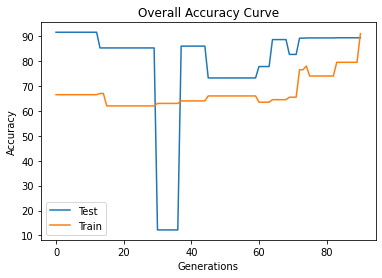

In [97]:
i = 4
dataset = 'thyroid'


plt.plot(range(len(modelInfo[dataset][i].testAccuracy)), modelInfo[dataset][i].testAccuracy , label= "Test")
plt.plot(range(len(modelInfo[dataset][i].trainAccuracy)), modelInfo[dataset][i].trainAccuracy, label = "Train" )
plt.xlabel("Generations")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy Curve") 
plt.legend()
plt.show()

In [ ]:
3